In [1]:
%matplotlib inline

import pickle as pkl
from collections import namedtuple, OrderedDict
from datetime import datetime
from urllib.request import urlopen
import json
from functools import lru_cache

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
Message = namedtuple("Message", ['person', 'sent_by_me', 'timestamp', 'sex']) 

messages = pkl.load(open("messages.pkl", 'rb'))
print("Total Messages: ", len(messages), "\n")

Total Messages:  284495 



In [50]:
msgs_by_day = {} # msgs[name] = [] * n_days, populated with message counts

start_date = datetime.strptime('9/1/15', "%m/%d/%y")
end_date = datetime.strptime('8/15/16', "%m/%d/%y")
delta = (end_date - start_date).days

for msg in messages:
    
    if msg.person in msgs_by_day.keys():
        if start_date < msg.timestamp < end_date:
                idx = (msg.timestamp - start_date).days
                msgs_by_day[msg.person][idx] += 1
    else:
        msgs_by_day[msg.person] = np.zeros(delta)


In [51]:
msgs_by_day = OrderedDict( sorted(msgs_by_day.items(), key=lambda i: -sum(i[1])) )

data = pd.DataFrame(msgs_by_day, index=pd.date_range(start_date, periods=delta))

/Users/rohanp/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=1).mean()
  app.launch_new_instance()


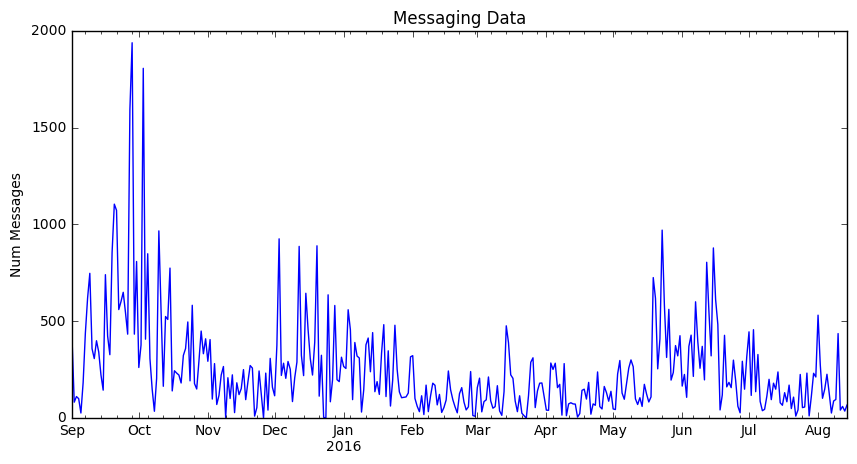

In [52]:
def everyonePlot(data, rolling_window=1):
    sum_data = data.iloc[:,:].sum(axis=1)
    return pd.rolling_mean(sum_data, rolling_window)

toPlot = everyonePlot(data, rolling_window=1)

ax = toPlot.plot(title="Messaging Data", figsize=(10, 5))
ax.set_ylabel("Num Messages")

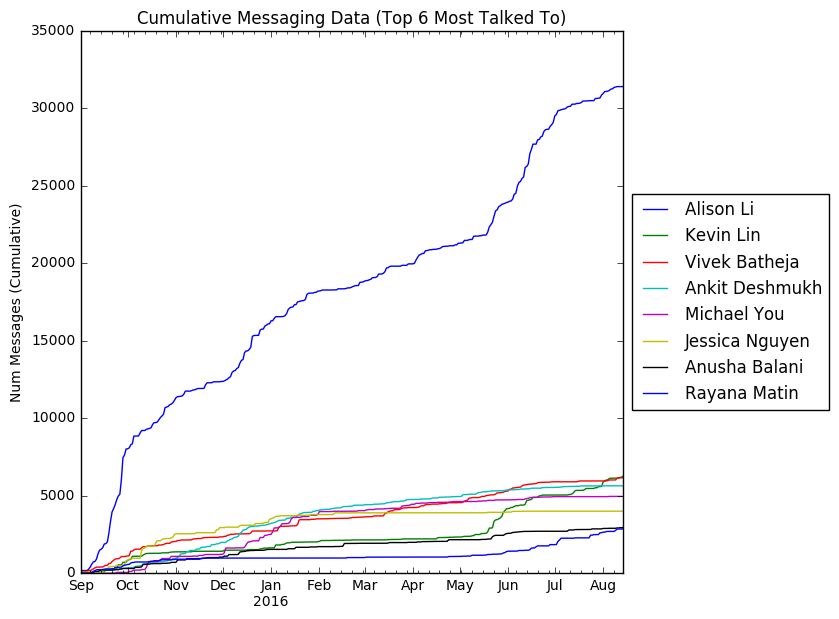

In [53]:
def cumMsgPlot(data, start, end):
    data = data.apply(np.cumsum)
    data = data.iloc[:, start:end]
    return data

toPlot = cumMsgPlot(data, start=0, end=8)

ax = toPlot.plot(title="Cumulative Messaging Data (Top 6 Most Talked To)", legend=True, figsize=(7,7))
ax.set_ylabel("Num Messages (Cumulative)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


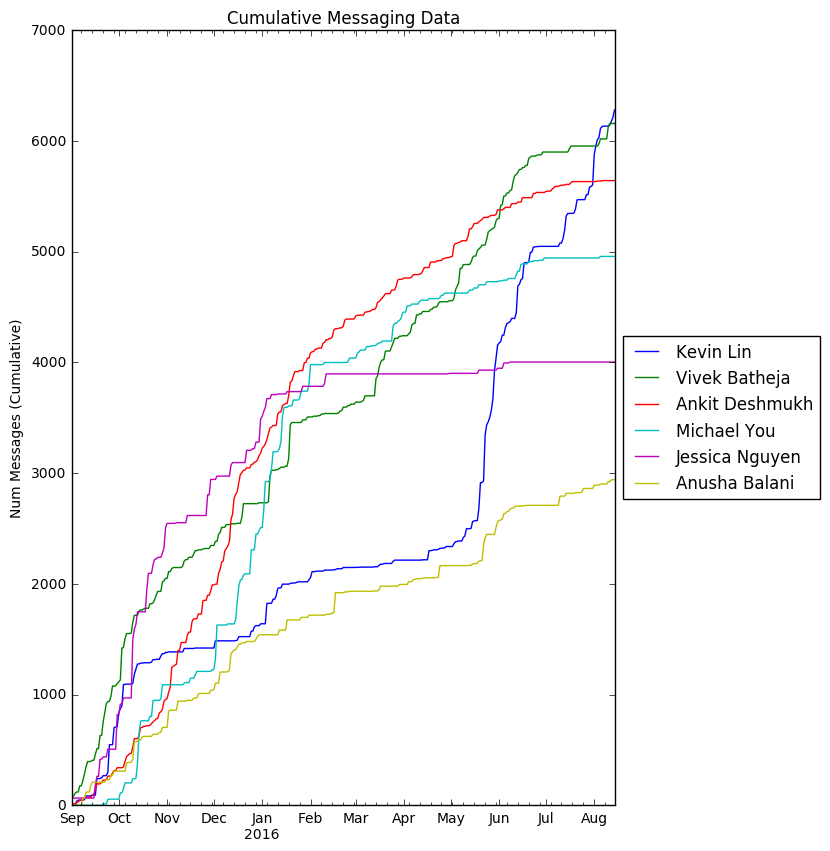

In [54]:
toPlot = cumMsgPlot(data, start=1, end=7)

ax = toPlot.plot(title="Cumulative Messaging Data", legend=True, figsize=(7,10))
ax.set_ylabel("Num Messages (Cumulative)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

/Users/rohanp/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=1).mean()


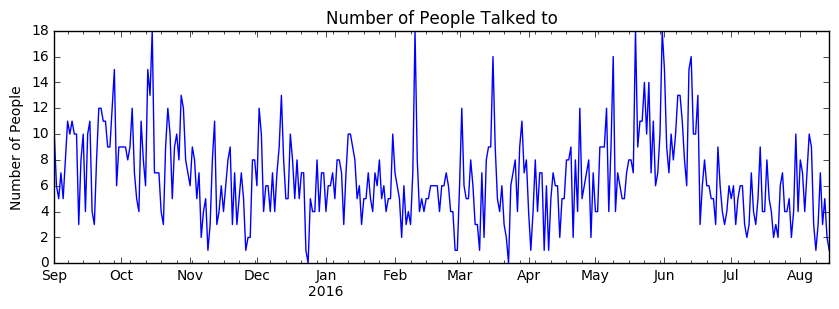

In [55]:
def numTalkedToPlot(data, min_messages=1, rolling_window=1):
    talkedTo = data[ min_messages < data ]
    talkedTo = ~pd.isnull(talkedTo)
    toPlot = talkedTo.iloc[:,:].sum(axis=1)
    return pd.rolling_mean(toPlot, rolling_window)

toPlot = numTalkedToPlot(data)

ax = toPlot.plot(title="Number of People Talked to", figsize=(10,3))
ax.set_ylabel("Number of People")

Lets smooth that over with a rolling mean

In [56]:
msgs_sex_by_day = {} # msgs[sex] = array of days 

for msg in messages:
    
    if msg.sex in msgs_sex_by_day.keys():
        if start_date < msg.timestamp < end_date:
                idx = (msg.timestamp - start_date).days
                msgs_sex_by_day[msg.sex][idx] += 1
    else:
        msgs_sex_by_day[msg.sex] = np.zeros(delta)

msgs_sex_by_day = OrderedDict( sorted(msgs_sex_by_day.items(), key=lambda i: -sum(i[1])) )

sex_data = pd.DataFrame(msgs_sex_by_day, index=pd.date_range(start_date, periods=delta))

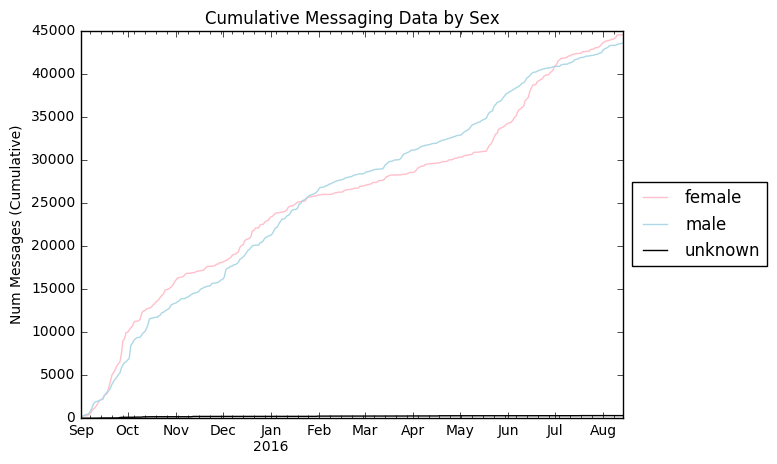

In [57]:
toPlot = cumMsgPlot(sex_data, start=0, end=10)

if toPlot.columns[0] == "female":
    color = ['pink', 'lightblue', 'black']
else:
    color = ['lightblue', 'pink', 'black']
    
ax = toPlot.plot(title="Cumulative Messaging Data by Sex", legend=True, 
                 color=color, figsize=(7,5))

ax.set_ylabel("Num Messages (Cumulative)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

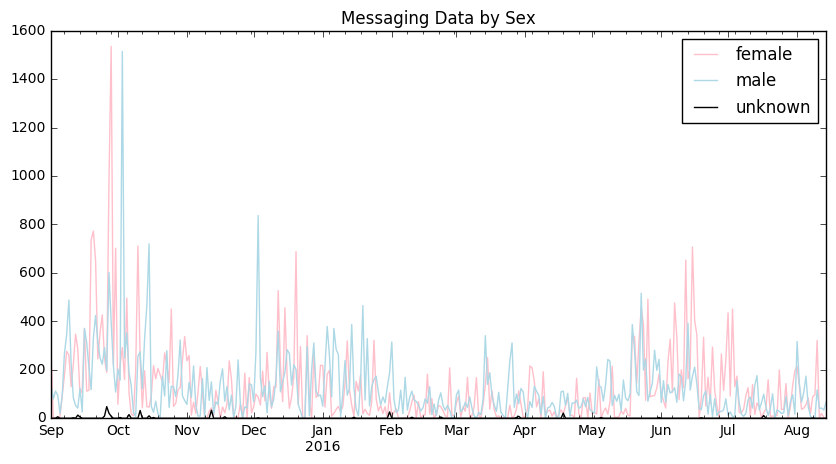

In [58]:
sex_data.plot(title="Messaging Data by Sex", legend=True, 
                 color=color, figsize=(10,5))

/Users/rohanp/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=6).mean()
  if __name__ == '__main__':


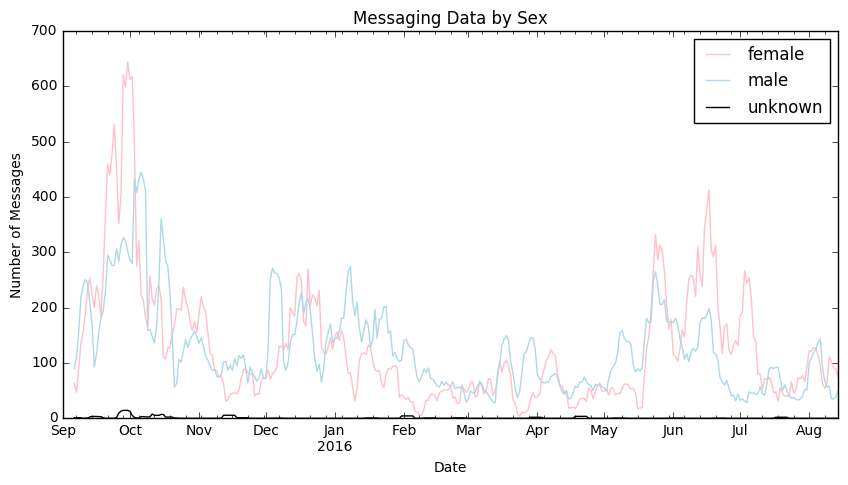

In [59]:
ax = pd.rolling_mean(sex_data, 6).plot(title="Messaging Data by Sex", legend=True, 
                 color=color, figsize=(10,5))

ax.set_ylabel("Number of Messages")
ax.set_xlabel("Date")

In [60]:
messages_in_range = filter(lambda x: start_date < x.timestamp < end_date, messages)

df = pd.DataFrame(list(messages_in_range), columns=Message._fields)
df = df[["person", "sent_by_me"]]
df.columns = ["person", "sent"]

df['received'] = pd.Series(~df["sent"], index=df.index)
df['total'] = df['sent'] | df['received']

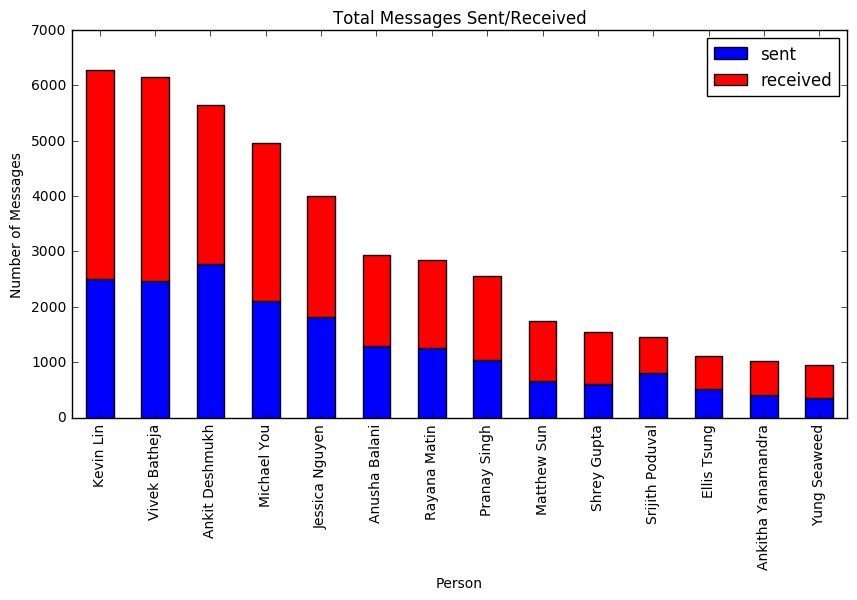

In [61]:
grouped = df.groupby('person')
sent_received = grouped.sum().sort_values('total', ascending=False)
toPlot = sent_received[["sent", "received"]].ix[1:15, :]

ax = toPlot.plot.bar(title="Total Messages Sent/Received", stacked=True, color=('b', 'r'), figsize=(10, 5))
ax.set_ylabel("Number of Messages")
ax.set_xlabel("Person")